# Optimal Control with Mixed Integer Programming

In this tutorial we will explore simulating a more complex scenario controlled by CommonPower's built-in model predictive controller. \
As exemplary case study we investigate how the control behaviour varies if we use perfect knowledge vs. "pressimistic" vs. "optimistic" forecasters.

In [1]:
import pathlib

import pandas as pd
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from numpy.random import uniform, normal, randint, choice
from pyomo.core import AbstractModel, ConcreteModel, Param, Set, Var, Constraint, Objective, value, quicksum
from copy import deepcopy
from randomtimestamp import randomtimestamp
from functools import partial

import pyomo.environ as pyo
from commonpower.core import Node, System, Bus
from commonpower.models.components import *
from commonpower.models.busses import *
from commonpower.models.lines import *
from commonpower.models.powerflow import *
from commonpower.extensions.factories import Factory, Sampler
from commonpower.data_forecasting import *
from commonpower.utils.param_initialization import *
from commonpower.control.controllers import *
from commonpower.control.safety_layer.safety_layers import *
from commonpower.control.logging.loggers import *
from commonpower.control.runners import *
from commonpower.control.wrappers import *
from commonpower.modelling import ModelHistory

from commonpower.extensions.network_import import PandaPowerImporter
import pandapower.networks as pn

## Parameters

In [2]:
horizon = 24  # number of control steps

frequency = timedelta(hours=1)

sim_steps = horizon * 10  # simulate 10 days

# for more randomness
#rand_seed = np.random.randint(1000)
#date_range = load_dp_a.get_date_range()
#test_day = randomtimestamp(start=date_range[0], end=date_range[1]-sim_steps*frequency, text=True, pattern="%d.%m.%Y") + " 00:00"

test_day = "23.02.2016"
rand_seed = 6

power_flow_mode = DCPowerFlowModel()  # running this with PowerBalanceModel() is solved significantly faster


## Data providers

In [3]:
# path to data profiles
current_path = pathlib.Path().absolute()
data_path = current_path / 'data'
data_path = data_path.resolve()

load_data_a = CSVDataSource(data_path  / '1-LV-rural2--1-sw' / 'LoadProfile.csv',
            delimiter=";", 
            datetime_format="%d.%m.%Y %H:%M", 
            rename_dict={"time": "t", "H0-A_pload": "p", "H0-A_qload": "q"},
            auto_drop=True, 
            resample=frequency).apply_to_column("p", lambda x: 10*x).apply_to_column("q", lambda x: 0.0)

load_data_b = CSVDataSource(data_path  / '1-LV-rural2--1-sw' / 'LoadProfile.csv',
            delimiter=";", 
            datetime_format="%d.%m.%Y %H:%M", 
            rename_dict={"time": "t", "H0-A_pload": "p", "H0-A_qload": "q"},
            auto_drop=True, 
            resample=frequency).apply_to_column("p", lambda x: 10*x).shift_time_series(timedelta(hours=24)).apply_to_column("q", lambda x: 0.0)

load_data_c = CSVDataSource(data_path  / '1-LV-rural2--1-sw' / 'LoadProfile.csv',
            delimiter=";", 
            datetime_format="%d.%m.%Y %H:%M", 
            rename_dict={"time": "t", "H0-B_pload": "p", "H0-B_qload": "q"},
            auto_drop=True, 
            resample=frequency).apply_to_column("p", lambda x: 10*x).apply_to_column("q", lambda x: 0.0)

price_data = CSVDataSource(data_path / 'spot_prices_dk.csv',
            delimiter=";", 
            decimal=",",
            datetime_format="%Y-%m-%d %H:%M", 
            rename_dict={"HourUTC": "t", "SpotPriceEUR": "psi"},
            auto_drop=True, 
            resample=frequency).apply_to_column("psi", lambda x: x/100)

pv_data_a = CSVDataSource(data_path / '1-LV-rural2--1-sw' / 'RESProfile.csv', 
        delimiter=";", 
        datetime_format="%d.%m.%Y %H:%M", 
        rename_dict={"time": "t", "PV3": "p"},
        auto_drop=True, 
        resample=frequency).apply_to_column("p", lambda x: -10*x)

pv_data_b = CSVDataSource(data_path / '1-LV-rural2--1-sw' / 'RESProfile.csv', 
        delimiter=";", 
        datetime_format="%d.%m.%Y %H:%M", 
        rename_dict={"time": "t", "PV7": "p"},
        auto_drop=True, 
        resample=frequency).apply_to_column("p", lambda x: -10*x)

# Temperature profile and COP Time-Series from the BDEW Dataset
temp_data = CSVDataSource(
    data_path / 'open-power-data/DE_Temperature_and_COP2016_PV_Open_Power_Load_BDEW.csv',
    delimiter=";",
    datetime_format="%d.%m.%Y %H:%M",
    rename_dict={"time": "t", "outside_temp": "T_outside", "COP": "COP"},
    auto_drop=True,
    resample=frequency)

load_dp_a = DataProvider(load_data_a, PerfectKnowledgeForecaster(frequency=frequency, horizon=timedelta(hours=horizon)))
load_dp_b = DataProvider(load_data_b, PerfectKnowledgeForecaster(frequency=frequency, horizon=timedelta(hours=horizon)))
load_dp_c = DataProvider(load_data_c, PerfectKnowledgeForecaster(frequency=frequency, horizon=timedelta(hours=horizon)))
price_dp = DataProvider(price_data, PerfectKnowledgeForecaster(frequency=frequency, horizon=timedelta(hours=horizon)))
pv_dp_a = DataProvider(pv_data_a, PerfectKnowledgeForecaster(frequency=frequency, horizon=timedelta(hours=horizon)))
pv_dp_b = DataProvider(pv_data_b, PerfectKnowledgeForecaster(frequency=frequency, horizon=timedelta(hours=horizon)))
temp_dp = DataProvider(temp_data, PerfectKnowledgeForecaster(frequency=frequency, horizon=timedelta(hours=horizon)))

# "pessimistic" noisy forecasters
# loads are overestimated; generation, temperature and heatpump cop are underestimated; prices are noisy without bias
load_dp_a_noisy_pess = DataProvider(load_data_a, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[0.0, 0.2]))
load_dp_b_noisy_pess = DataProvider(load_data_b, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[0.0, 0.2]))
load_dp_c_noisy_pess = DataProvider(load_data_c, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[0.0, 0.2]))
price_dp_noisy_pess = DataProvider(price_data, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[-0.2, 0.2]))
pv_dp_a_noisy_pess = DataProvider(pv_data_a, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[-0.2, 0.0]))
pv_dp_b_noisy_pess = DataProvider(pv_data_b, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[-0.2, 0.0]))
temp_dp_noisy_pess = DataProvider(temp_data, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[-0.1, 0.0]))

# "optimistic" noisy forecasters
# loads are underestimated; generation, temperature and heatpump cop are overestimated; prices are noisy without bias
load_dp_a_noisy_opt = DataProvider(load_data_a, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[-0.2, 0.0]))
load_dp_b_noisy_opt = DataProvider(load_data_b, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[-0.2, 0.0]))
load_dp_c_noisy_opt = DataProvider(load_data_c, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[-0.2, 0.0]))
price_dp_noisy_opt = DataProvider(price_data, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[-0.2, 0.2]))
pv_dp_a_noisy_opt = DataProvider(pv_data_a, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[0.0, 0.2]))
pv_dp_b_noisy_opt = DataProvider(pv_data_b, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[0.0, 0.2]))
temp_dp_noisy_opt = DataProvider(temp_data, NoisyForecaster(frequency=frequency, horizon=timedelta(hours=horizon), noise_bounds=[0.0, 0.1]))

### System setup

This is the first tutorial in which we use non-linear components, e.g. ESS, EV, and heat pump. \
All of the predefined models are at most quadratically constrained with quadratic cost functions. \
Since we model piecewise-linear behavior (e.g. charge/discharge) via binary indicator variables, we end up with a Mixed Integer Quadratically Constrained Quadratic Program (MIQCQP). \
By our experience, our default solver Gurobi can handle this type of problem with reasonable efficiency.

The system model in this tutorial has 452 quadratic objective terms, 752 quadratic constraints (4486 continuous variables, 2575 integer (binar) variables) and is usually solved to an optimality gap < 0.5% in under 1 min (per timestep). \
Including components with more complex non-linear models or scaling the number of entities might result in vastly longer solve times. \
Note that as soon as we venture in the realm of Mixed Integer Programming or Quadratic Programming we generally lose guarantees to find the globally optimal solution in polynomial time.

In [4]:
def spawn_sys(
        load_dp_a, load_dp_b, load_dp_c,
        pv_dp_a, pv_dp_b,
        temp_dp,
        price_dp
    ) -> System:
    
    np.random.seed(rand_seed)

    factory = Factory()

    factory.set_bus_template(Bus, meta_config={
                                    "p": Sampler(uniform, low=[-1e6, 1e6], high=[-1e6, 1e6]), 
                                    "q": Sampler(uniform, low=[-1e6, 1e6], high=[-1e6, 1e6]),
                                    "v": Sampler(uniform, low=[0.9, 1.1], high=[0.9, 1.1]),
                                    "d": Sampler(uniform, low=[-15, 15], high=[-15, 15])
                                })

    # add components to factory
    # Load: base load of the household (corresponds to fridge, dishwasher, washing machine, etc.)
    factory.add_component_template(Load, probability=1., data_providers=[Sampler(choice, a=[load_dp_a, load_dp_b, load_dp_c])])
    # RenewableGen: renewable generation (e.g., PV)
    factory.add_component_template(RenewableGen, probability=.7, meta_config={
                                    "p": Sampler(uniform, low=[-7, 0], high=[-7, 0]), 
                                    "q": Sampler(uniform, low=[0, 0], high=[0, 0])
                                    }, 
                                data_providers=[Sampler(choice, a=[pv_dp_a, pv_dp_b])]
                                )

    factory.add_component_template(ESS, probability=0.4, meta_config={
        'rho': 0.01, 
        'p': Sampler(uniform, low=[-5, 5], high=[-5, 5]), 
        'q': Sampler(uniform, low=[0, 0], high=[0, 0]), 
        'etac': 0.98,
        'etad': 0.98,
        'etas': 0.99,
        'soc': Sampler(uniform, low=[2, 8], high=[2, 15]), 
        "soc_init": [ConstantInitializer, {"val": 3.0}]
    })

    factory.add_component_template(EV, probability=0.4, meta_config={
        "p": Sampler(uniform, low=[-15, 15], high=[-20, 20]),
        "soc": Sampler(uniform, low=[2, 25], high=[2, 60]),
        "rho": 0.02,
        "etac": 0.95,
        "etad": 0.95,
        "etas": 0.99,
        "departure": Sampler(randint, low=8, high=11),
        "return": Sampler(randint, low=16, high=21),
        "req_soc_rel": Sampler(uniform, low=0.5, high=0.9),
        "soc_init": [ConstantInitializer, {"val": 5.0}]
    })

    factory.add_component_template(HeatPumpWithoutStorageButCOP, probability=0.3, meta_config={
            'p': [0, 5],  # kW
            # 'q': [0, 5],  # kW
            'T_indoor_setpoint': 21,  # °C
            'T_indoor': [12, 32],  # °C indoor temperature range
            "T_indoor_init": [ConstantInitializer, {"val": 21.0}],
            'T_ret_FH': [10, 100],
            'T_ret_FH_init': [ConstantInitializer, {"val": 25.0}],
            'H_FH': 1.1,  # kW/K
            'H_out': 0.26,  # kW/K
            'tau_building': 240,  # h
            'Cw_FH': 1.1625,  # kWh/K
            'c': 1000  # weighting factor for cost function; multiplied with comfort deviation
        }, 
        data_providers=[temp_dp]
    )

    # initialize system
    net = pn.create_kerber_landnetz_kabel_2()
    sys = PandaPowerImporter().import_net(net=net, power_flow_model=power_flow_mode, node_factory=factory, restrict_factory_to="loadbus")

    trading_node = TradingBusLinear("TradingBus", {}).add_data_provider(price_dp)

    # set node 1 (main_busbar) as external grid connection, i.e. trading node
    sys.add_node(trading_node, at_index=1)

    # update the respective lines
    sys.lines[0].src = trading_node
    sys.lines[24].src = trading_node

    # remove line from ext to main busbar
    sys.lines.pop(-1)
    # remove node 0
    sys.nodes.pop(0)
    # Show the system set-up
    sys.pprint()
    
    return sys

### Solver setup

More complex scenarios might need solver tuning, for parameters of the Gurobi solver refer to [Gurobi Solver Parameters](https://www.gurobi.com/documentation/current/refman/parameters.html).

CommonPower's default solver options only include very basic settings, we state them below for transparency. 

One parameter which can greatly influence the solve time of MIPs is the optimality gap (MIPGap). \
It essentially allows a direct trade-off between computation time and the objective value of MI-feasible solutions. \
By our experience, a value of 0.5% optimality gap (default is 0.01%) is a resonable value.

Another important parameter is the integrality tolerance (i.e. what the solver still considers an integer). 
We set this very low by default as there exisits a direct relationship with the BigM constraints we use for binary indicator variables. \
We recommend to not decrease this value if in any way avoidable.

In [5]:
from pyomo.environ import SolverFactory

solver_oc = SolverFactory('gurobi')  # this is the "actual" model predictive controller
solver_sys = SolverFactory('gurobi')  # this is the system solver to solve for all non-controlled variables

DEFAULT_SOLVER_OPTIONS = {
    "MIPFocus": 1,  # focus on feasible solutions not optimality
    "IntFeasTol": 1e-9,  # integrality tolerance. Important for MIPs, see MIPExpressionBuilder
    "TimeLimit": 60,  # limit solve time to 60s
}
solver_oc.options.update(DEFAULT_SOLVER_OPTIONS)
solver_sys.options.update(DEFAULT_SOLVER_OPTIONS)

solver_oc.options["MIPGap"] = "0.005"  # 0.5%
solver_sys.options["MIPGap"] = "0.005"  # 0.5%

solver_oc.options["LogFile"] = "solver_oc.log"  # prints the solver log to file
solver_sys.options["LogFile"] = "solver_sys.log"  # prints the solver log to file

## Simulation

### Perfect forecasts

In [ ]:
pk_sys = spawn_sys(load_dp_a, load_dp_b, load_dp_c,
        pv_dp_a, pv_dp_b,
        temp_dp,
        price_dp)

pk_sys_history = ModelHistory([pk_sys])
runner = DeploymentRunner(sys=pk_sys, global_controller=OptimalController("global", solver=solver_oc), fixed_day=test_day, seed=rand_seed, continuous_control=True, history=pk_sys_history, solver=solver_sys)
runner.run(n_steps=sim_steps)

### Pessimistic noisy forecasts

In [ ]:
noisy_pess_sys = spawn_sys(load_dp_a_noisy_pess, load_dp_b_noisy_pess, load_dp_c_noisy_pess,
        pv_dp_a_noisy_pess, pv_dp_b_noisy_pess,
        temp_dp_noisy_pess,
        price_dp)

noisy_pess_sys_history = ModelHistory([noisy_pess_sys])
runner = DeploymentRunner(sys=noisy_pess_sys, global_controller=OptimalController("global", solver=solver_oc), fixed_day=test_day, seed=rand_seed, continuous_control=True, history=noisy_pess_sys_history, solver=solver_sys)
runner.run(n_steps=sim_steps)

### Optimistic noisy forecasts

In [ ]:
noisy_opt_sys = spawn_sys(load_dp_a_noisy_opt, load_dp_b_noisy_opt, load_dp_c_noisy_opt,
        pv_dp_a_noisy_opt, pv_dp_b_noisy_opt,
        temp_dp_noisy_opt,
        price_dp)

noisy_opt_sys_history = ModelHistory([noisy_opt_sys])
runner = DeploymentRunner(sys=noisy_opt_sys, global_controller=OptimalController("global", solver=solver_oc), fixed_day=test_day, seed=rand_seed, continuous_control=True, history=noisy_opt_sys_history, solver=solver_sys)
runner.run(n_steps=sim_steps)

## Evaluation

With regards to heat pump control we can see two effects of the noisy forecast: \
First, the control of each heat pump varies noticeably while with perfect forecasts all heat pumps are controlled almost identically. \
Second, the pessimistic forecast unsurprisingly leads to a higher average indoor temperature (because the forecaster expects a lower temperature and the controller steers against that). \
The converse holds true for the optimistic forecast.

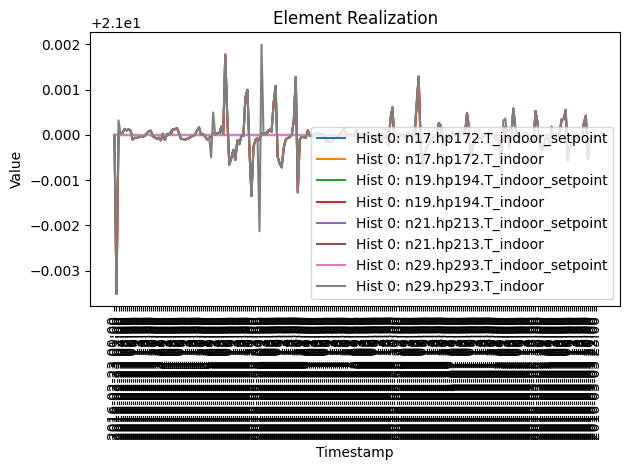

In [21]:
hist = pk_sys_history.filter_for_entity_types(HeatPumpWithoutStorageButCOP).filter_for_element_names(["T_indoor", "T_indoor_setpoint"]).plot(return_time_series=True)

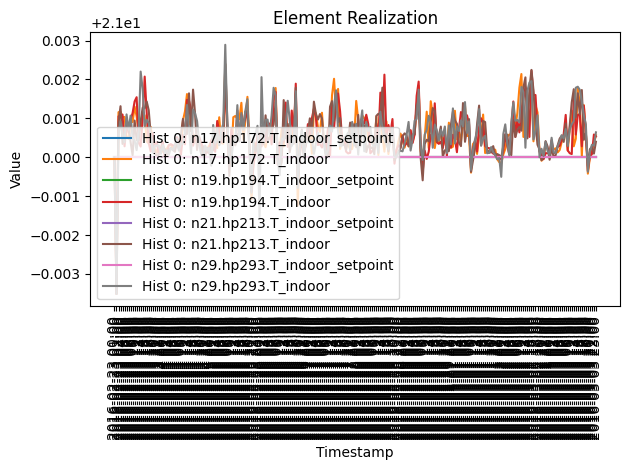

In [10]:
hist = noisy_pess_sys_history.filter_for_entity_types(HeatPumpWithoutStorageButCOP).filter_for_element_names(["T_indoor", "T_indoor_setpoint"]).plot(return_time_series=True)

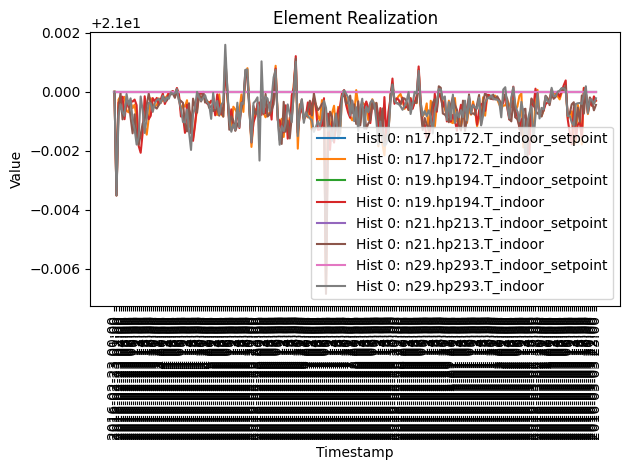

In [15]:
hist = noisy_opt_sys_history.filter_for_entity_types(HeatPumpWithoutStorageButCOP).filter_for_element_names(["T_indoor", "T_indoor_setpoint"]).plot(return_time_series=True)

With regards to the total system cost we can see that, somewhat surprisingly, the noisy forecasts only increase the sysem cost by a negligible amount. \
Apparently, the controller has enough degrees of freedom to operate optimally even with the present noise.

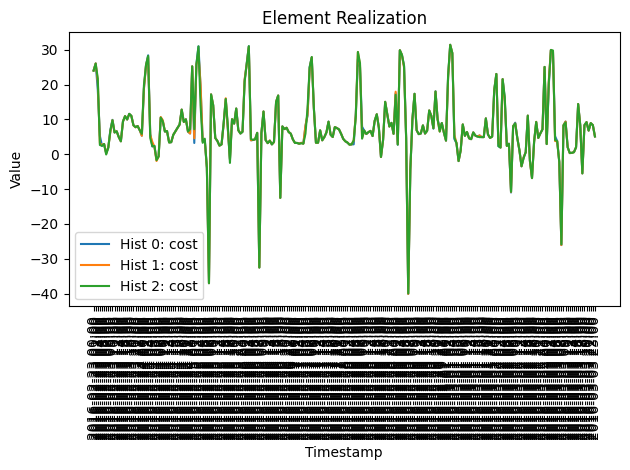

In [18]:
pk_cost = pk_sys_history.filter_for_entity_types(System).filter_for_element_names(["cost"])
noisy_pess_cost = noisy_pess_sys_history.filter_for_entity_types(System).filter_for_element_names(["cost"])
noisy_opt_cost = noisy_opt_sys_history.filter_for_entity_types(System).filter_for_element_names(["cost"])
costs = pk_cost.plot([noisy_pess_cost, noisy_opt_cost], return_time_series=True)

In [19]:
for c, v in costs.items():
    print(f"{c} : {sum(v)}")

Hist 0: cost : 1844.2534087476556
Hist 1: cost : 1844.862222388756
Hist 2: cost : 1844.4378715985986
